### Задание 5.3.

У нас параллельно шли два A/B-теста, оба – с 30 июня по 6 июля 2023: 
1) Первый:

* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

2) Второй:

* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

#### Задача 
* Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
* Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?


In [1]:
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import pandahouse

In [2]:
# Загружаем данные о количестве просмотров и лайков полизователей из 2 и 1 экспериментальной группы за период с 30 июня по 6 июля, считаем их CTR
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'******',
                      'user':'student', 
                      'password':'******'
                     }


query = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

df.head()

,exp_group,user_id,likes,views,ctr
0,1,18392,7,32,0.218750
1,3,115383,12,44,0.272727
2,3,123580,2,11,0.181818
3,2,131473,9,108,0.083333
4,4,107323,5,31,0.161290


In [3]:
# разделим датасет на 2 по количеству A/B-тестов
test1 = df[(df['exp_group'] == 1)|(df['exp_group'] == 2)].reset_index()
test2 = df[(df['exp_group'] == 0)|(df['exp_group'] == 3)].reset_index()

****

#### Проанализируем первый тест (группы 1 и 2) по метрике линеаризированных лайков 

In [4]:
# Посмотрим на количество пользователей в группах
test1.exp_group.value_counts()

1    10020
2     9877
Name: exp_group, dtype: int64

In [5]:
# Посчитаем глобальный CTR контрольной группы теста №1 (exp_group = 1)
ctr_control1 = test1[test1['exp_group'] == 1].likes.sum()/test1[test1['exp_group'] == 1].views.sum()
ctr_control1

0.2096041628394293

In [6]:
# Добавим столбец с метрикой линеаризированных лайков
test1['linearized_likes'] = test1.likes - ctr_control1 * test1.views
test1

,index,exp_group,user_id,likes,views,ctr,linearized_likes
0,0,1,18392,7,32,0.218750,0.292667
1,3,2,131473,9,108,0.083333,-13.637250
2,5,2,32420,13,44,0.295455,3.777417
3,6,2,24239,40,90,0.444444,21.135625
4,8,1,27443,22,109,0.201835,-0.846854
...,...,...,...,...,...,...,...
19892,49802,1,21697,2,22,0.090909,-2.611292
19893,49804,2,1232,5,96,0.052083,-15.122000
19894,49807,1,120653,8,42,0.190476,-0.803375
19895,49811,1,132567,52,326,0.159509,-16.330957


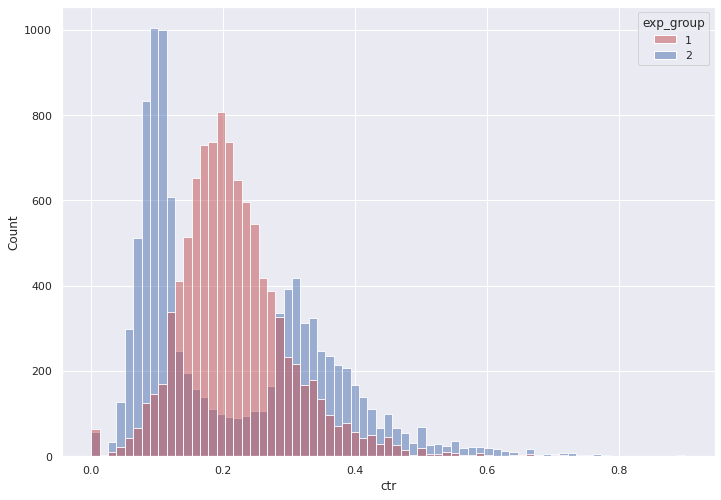

In [7]:
# Нарисуем распределение CTR в группах

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = test1,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

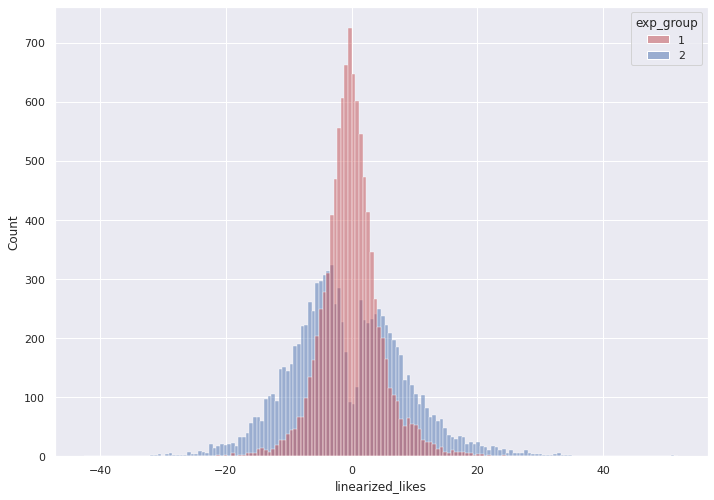

In [8]:
# Нарисуем распределение линеаризированных лайков

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = test1,
              x='linearized_likes',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим, что формы распределений линеаризированных лайков похожи на распределения CTR. Средние значения метрики линеаризированных лайков находятся около 0.

In [9]:
# Применим t-тест к CTR 
stats.ttest_ind(test1[test1.exp_group == 1].ctr,
                test1[test1.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [10]:
# Применим t-тест к линеаризированным лайкам 
stats.ttest_ind(test1[test1.exp_group == 1].linearized_likes,
                test1[test1.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

При сравнении поюзерных CTR в рамках первого эксперимента t-тест не позволяет сделать вывод о существовании значимых различий между группами 1 и 2. В то же время, при применении этого теста для сравнения метрики линеаризированных лайков были получены довольно высокое значение t-статистики и p-value ниже 0.5. Таким образом, в данном случае эта метрика помогла нам найти различия там, где они действительно есть, то есть не совершить ошибку второго рода 

****

#### Проанализируем второй тест (группы 0 и 3) по метрике линеаризированных лайков 

In [11]:
# Посмотрим на количество пользователей в группах
test2.exp_group.value_counts()

3    10002
0     9920
Name: exp_group, dtype: int64

In [12]:
# Посчитаем глобальный CTR контрольной группы теста №2 (exp_group = 1)
ctr_control2 = test2[test2['exp_group'] == 0].likes.sum()/test2[test2['exp_group'] == 0].views.sum()
ctr_control2

0.20983799195924746

In [13]:
# Добавим столбец с метрикой линеаризированных лайков
test2['linearized_likes'] = test2.likes - ctr_control2 * test2.views
test2

,index,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,3,115383,12,44,0.272727,2.767128
1,2,3,123580,2,11,0.181818,-0.308218
2,7,0,30319,25,114,0.219298,1.078469
3,9,3,118359,7,38,0.184211,-0.973844
4,11,0,7626,14,39,0.358974,5.816318
...,...,...,...,...,...,...,...
19917,49795,0,110492,4,17,0.235294,0.432754
19918,49808,0,136299,35,116,0.301724,10.658793
19919,49809,0,27030,12,64,0.187500,-1.429631
19920,49810,3,122758,20,118,0.169492,-4.760883


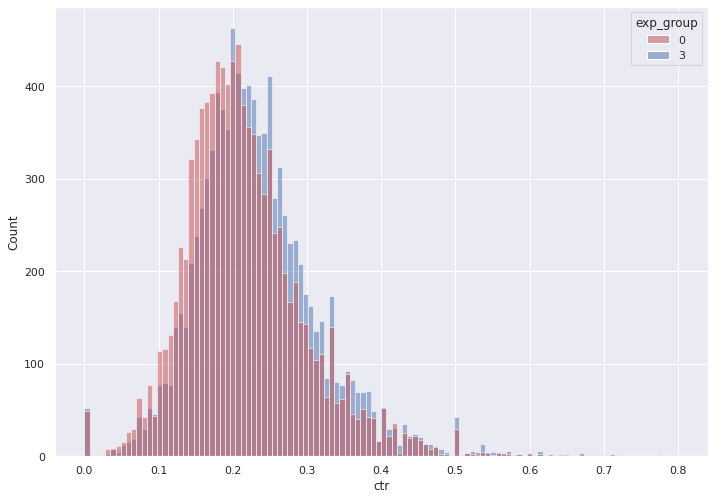

In [14]:
# Нарисуем распределение CTR в группах

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = test2,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

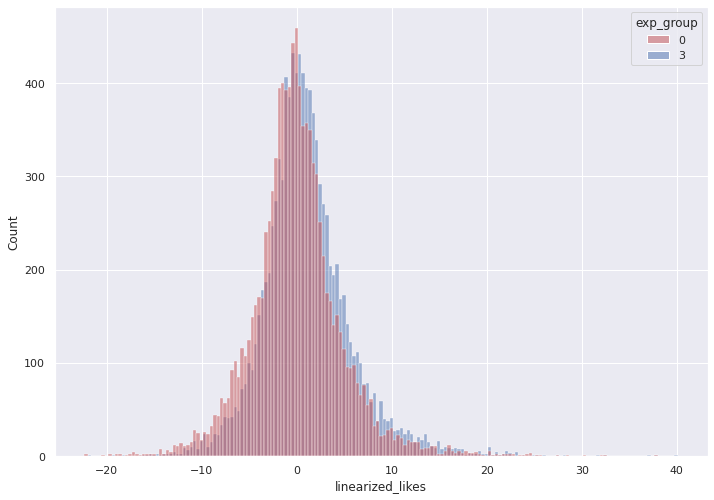

In [15]:
# Нарисуем распределение линеаризированных лайков

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = test2,
              x='linearized_likes',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [16]:
# Применим t-тест к CTR 
stats.ttest_ind(test2[test2.exp_group == 0].ctr,
                test2[test2.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [17]:
# Применим t-тест к линеаризированным лайкам 
stats.ttest_ind(test2[test2.exp_group == 0].linearized_likes,
                test2[test2.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

В случае со вторым экспериментом применение t-теста и на поюзерных CTR, и на линеризированных лайках позволяет отклонить гипотезу о равенстве групп 0 и 3. Важно отметить, что, как и в случае с первым экспериментом, мощность теста на линеаризированных лайках оказалась выше, о чем свидетельствуют более высокое (по модулю) значение t-статистики и меньшее p-value.

***

#### Вывод:

Применение t-теста на метрике линеаризованных лайков в случае обоих экспериментов дало более низкое значение p-value, чем применение его напрямую к интересующей нас метрике - пользовательским CTR.

Если в случае второго эксперимента мы имели основания для отклонения гипотезы о равенстве средних в группах 0 и 3 и без конструирования новой метрики, то в рамках первого этот метод позволил нам обнаружить статистически значимые различия между группами 1 и 2, которые не мог обнаружить t-тест на CTR.

Продуктовые рекомендации:
1) по результатам первого A/B-теста алгоритм рекомендаций "похожих на лайкнутые постов" не рекомендуется раскатывать на всех пользователей, так как он приводит к снижению CTR (об этом свидетелельствует высокое положительное значение t-статитики, полученное при сравнении метрики линеаризированных лайков между группами 1 и 2);
2) по результатам второго A/B-теста алгоритм рекомендаций "постов, которые лайкали похожие на пользователя люди" рекомендуется раскатить на всех пользователей, так как он приводит к увеличению CTR (об этом свидетелельствует высокое (по модулю) отрицательное значение t-статитики, полученное при сравнении метрики линеаризированных лайков между группами 0 и 3).